# Install packages

In [1]:
import sys

import numpy as np 
import pandas as pd 

from fastcore.all import *
from fastai.vision.all import *
from time import sleep
from pathlib import Path

from fastdownload import download_url
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.optimizers import Adam, SGD
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

import matplotlib.pyplot as plt
import random
from PIL import Image

import os
import shutil
import pickle

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

functions_path = '/kaggle/input/py-files/'
sys.path.append(functions_path)

from functions import *

2024-06-14 05:11:46.535069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 05:11:46.535289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 05:11:46.722740: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Source images

In [2]:
class Images:
    '''
    A class to source images.
    
    Attributes:
    ----------
    num_images: float
        
    Methods:
    -------
    define_paths()
        ***
    
        
    '''
    def __init__(self, num_images):
        self.num_images = num_images
        self.orig_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'
        self.dest_dir = '/kaggle/working/cifake'
    
    def copy_images(self):
        categories = ['FAKE', 'REAL']
        dataset_type = ['train', 'test']
        
        #Copy train & test images
        for i in dataset_type:
            for j in categories:
                orig_dir = os.path.join(self.orig_dir, i, j)
                dest_dir = os.path.join(self.dest_dir, i, j) 
                source_images(orig_dir = orig_dir, dest_dir = dest_dir, num_images = self.num_images, seed = 23)
        #Copy validation images
        for j in categories:
            train_dir= os.path.join(self.dest_dir, 'train', j)
            validation_dir = '/kaggle/working/cifake/validation'
            
            all_files = os.listdir(train_dir)
            random.seed(23)
            selected_files = random.sample(all_files, 100)
            
            for file in selected_files:
                train_file_path = os.path.join(train_dir, file)
                validation_file_path = os.path.join(validation_dir, j, file)
                os.makedirs(validation_file_path, exist_ok=True)
                shutil.copy(train_file_path, validation_file_path)

                os.remove(train_file_path)

# Preprocess images

In [3]:
class Preprocess:
    def __init__(self, batch_size, target_size):
        self.batch_size = batch_size
        self.target_size = target_size
        self.train_dir = '/kaggle/working/cifake/train'
        self.test_dir = '/kaggle/working/cifake/test'
        self.validation_dir = '/kaggle/working/cifake/validation'
        self.classes = ['REAL', 'FAKE']
    
    def create_generators (self):
        train_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest')
        
        train_generator = train_datagen.flow_from_directory(
            self.train_dir, 
            target_size=self.target_size,
            batch_size=self.batch_size,
            classes=self.classes)
        
        validation_generator = ImageDataGenerator().flow_from_directory(
            self.validation_dir,
            target_size=self.target_size,
            batch_size=self.batch_size,
            classes=self.classes)
        
        test_generator = ImageDataGenerator().flow_from_directory(
            self.test_dir,
            target_size=self.target_size,
            batch_size=self.batch_size,
            classes=self.classes,
            shuffle = False)
        
        return train_generator, validation_generator, test_generator 

# Create CNN model

In [4]:
class CNN_model:
    def __init__(self, train_generator, validation_generator, activation, optimizer, steps_per_epoch, epochs, validation_steps, dropout, cnn_dict):
        self.train_generator = train_generator
        self.validation_generator = validation_generator
        self.activation = activation
        self.optimizer = optimizer
        self.steps_per_epoch = steps_per_epoch
        self.epochs = epochs
        self.validation_steps = validation_steps
        self.dropout = dropout
        self.cnn_dict = cnn_dict
    
    def define_architecture(self):
        model = Sequential()

        #Convolutional layers
        for conv in self.cnn_dict['conv_layers']:
            model.add(Conv2D(
                filters = conv['filters'],
                kernel_size = conv['kernel_size'],
                activation = self.activation,
                input_shape=self.cnn_dict['input_shape'] if len(model.layers) == 0 else None))

            model.add(MaxPooling2D(pool_size=(2,2)))

        #Flatten
        model.add(Flatten())

        #Dropout
        model.add(Dropout(self.dropout))

        #Dense layers
        for dense in self.cnn_dict['dense_layers']:
            model.add(Dense(
                units = dense['units'],
                activation = self.activation))

        #Output
        model.add(Dense(
            units = 2,
            activation = 'softmax'))

        return model
    
    def compile_model(self):
        model = self.define_architecture()
        model.compile(
            loss='categorical_crossentropy',
            optimizer= self.optimizer,
            metrics=['accuracy'])
        return model
        
    def fit_model (self):
        model = self.compile_model()
        history = model.fit(train_generator,
                            steps_per_epoch = self.steps_per_epoch,
                            epochs = self.epochs,
                            validation_data = validation_generator,
                            validation_steps = self.validation_steps)
        return history, model

    def save_model(self, model_filename, history_filename):
        history, model = self.fit_model()
        model.save(os.path.join('/kaggle/working', model_filename))
        
        with open(os.path.join('/kaggle/working', history_filename), 'wb') as file:
            pickle.dump(history.history, file)

# Train and save 5 CNN models

In [5]:
# Source images---
images = Images(500)

#Preprocess & create train, validation, & test generators
generators = Preprocess(32, (224, 224))
train_generator, validation_generator, test_generator = generators.create_generators()

# #Base---
# activation = 'relu'
# optimizer = 'adam'
# steps_per_epoch = 100
# epochs = 20
# validation_steps = 50
# dropout = 0.5

# base_dict = {
#     'input_shape': (224, 224, 3),
#     'conv_layers': [
#         {'filters': 32, 'kernel_size': (3, 3)},
#         {'filters': 32, 'kernel_size': (3, 3)}
#     ],
    
#     'dense_layers': [
#         {'units': 512}
#     ]
# }

# base = CNN_model(train_generator, validation_generator, activation, optimizer, steps_per_epoch, epochs, validation_steps, dropout, base_dict)
# base.save_model('cifake_base.h5', 'history_cifake_base.pkl')

# #Sigmoid---
# activation = 'sigmoid'
# optimizer = 'adam'
# steps_per_epoch = 100
# epochs = 20
# validation_steps = 50

# sigmoid_model = CNN_model(train_generator, validation_generator, activation, optimizer, steps_per_epoch, epochs, validation_steps, base_dict)
# sigmoid_model.save_model('cifake_sigmoid.h5', 'history_cifake_sigmoid.pkl')

# #Epoch---
# activation = 'relu'
# optimizer = 'adam'
# steps_per_epoch = 100
# epochs = 30
# validation_steps = 50

# epoch = CNN_model(train_generator, validation_generator, activation, optimizer, steps_per_epoch, epochs, validation_steps, base_dict)
# epoch.save_model('cifake_epoch.h5', 'history_cifake_epoch.pkl')

# #SGD---
# activation = 'relu'
# optimizer = 'SGD'
# steps_per_epoch = 100
# epochs = 20
# validation_steps = 50

# sgd = CNN_model(train_generator, validation_generator, activation, optimizer, steps_per_epoch, epochs, validation_steps, base_dict)
# sgd.save_model('cifake_sgd.h5', 'history_cifake_sgd.pkl')

# #Valsteps
# activation = 'relu'
# optimizer = 'adam'
# steps_per_epoch = 100
# epochs = 20
# validation_steps = 100

# valsteps = CNN_model(train_generator, validation_generator, activation, optimizer, steps_per_epoch, epochs, validation_steps, base_dict)
# valsteps.save_model('cifake_valsteps.h5', 'history_cifake_valsteps.pkl')

Found 800 images belonging to 2 classes.
Found 735 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Load models after train

In [6]:
#Load the models
base = load_model('/kaggle/input/cifar/tensorflow2/base/1/cifake_base.h5')
sgd = load_model('/kaggle/input/cifar/tensorflow2/sgd/1/cifake_sgd.h5')
valsteps = load_model('/kaggle/input/cifar/tensorflow2/valsteps/1/cifake_valsteps.h5')
sigmoid_model = load_model('/kaggle/input/cifar/tensorflow2/sigmoid/1/cifake_sigmoid.h5')
epoch = load_model('/kaggle/input/cifar/tensorflow2/epoch/1/cifake_epoch.h5')

#Load history
with open('/kaggle/input/model-histories/history_cifake_base.pkl', 'rb') as file:
    base_history = pickle.load(file)
with open('/kaggle/input/model-histories/history_cifake_epoch.pkl', 'rb') as file:
    epoch_history = pickle.load(file)
with open('/kaggle/input/model-histories/history_cifake_sgd.pkl', 'rb') as file:
    sgd_history = pickle.load(file)
with open('/kaggle/input/model-histories/history_cifake_sigmoid.pkl', 'rb') as file:
    sigmoid_history = pickle.load(file)
with open('/kaggle/input/model-histories/history_cifake_valsteps.pkl', 'rb') as file:
    valsteps_history = pickle.load(file)

# Evaluate models

In [7]:
class Evaluate_model:
    def __init__(self, test_generator):
        self.test_generator = test_generator
        self.test_table = pd.DataFrame()
        self.histories = []
        self.history_names = []
        
    def add_history(self, history, name):
        self.histories.append(history)
        self.history_names.append(name)
        
    def visualize_training(self, metrics):
        calc_histories(metrics, self.histories, self.history_names)
        
    def calc_metrics(self, model, name):
        row, accuracy, precision, recall, f1, y_true, y_pred_classes, y_pred = calc_eval_metrics(model, name, self.test_generator)
        self.test_table = pd.concat([self.test_table, row], ignore_index = True)
        return accuracy, precision, recall, f1, y_true, y_pred_classes, y_pred
    
    def plot_confusion_matrix(self, model, name):
        accuracy, precision, recall, f1, y_true, y_pred_classes, y_pred = self.calc_metrics(model, name)
        calc_confusion_matrix(y_true, y_pred_classes, name)
        
    def plot_roc_curve(self, model, name):
        accuracy, precision, recall, f1, y_true, y_pred_classes, y_pred = self.calc_metrics(model, name)
        n_classes = self.test_generator.num_classes
        y_test_bin = label_binarize(y_true, classes=[0, 1]) 
        
        calc_roc_curve(n_classes, y_true, y_pred, name)

# Run evaluation

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 730ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 700ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 719ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 715ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 709ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 714ms/step


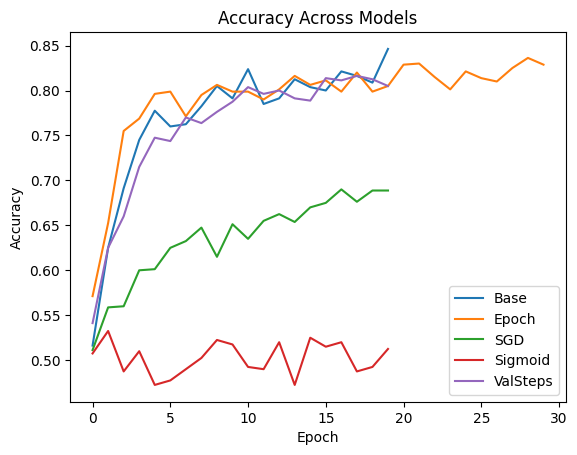

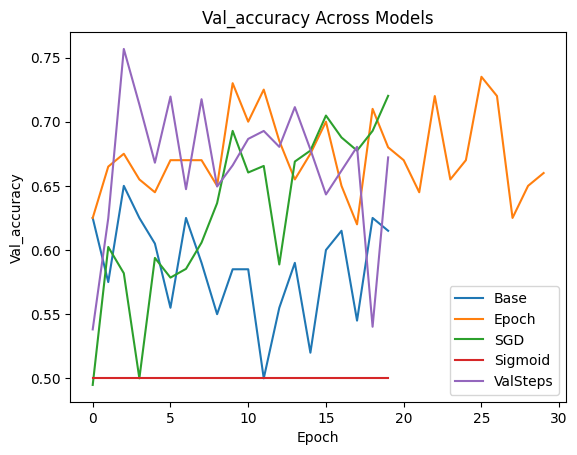

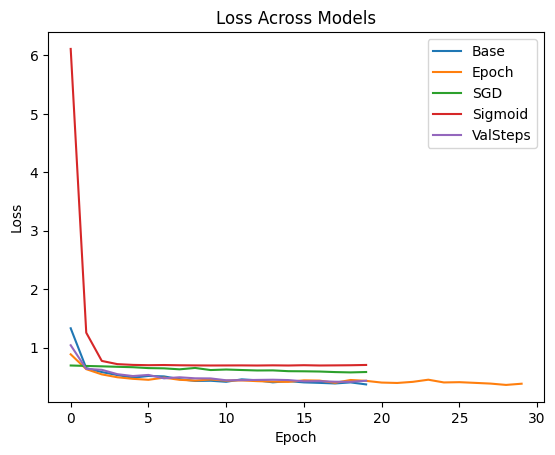

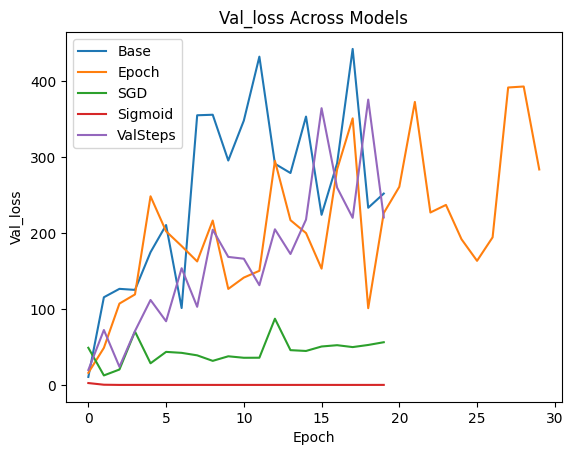

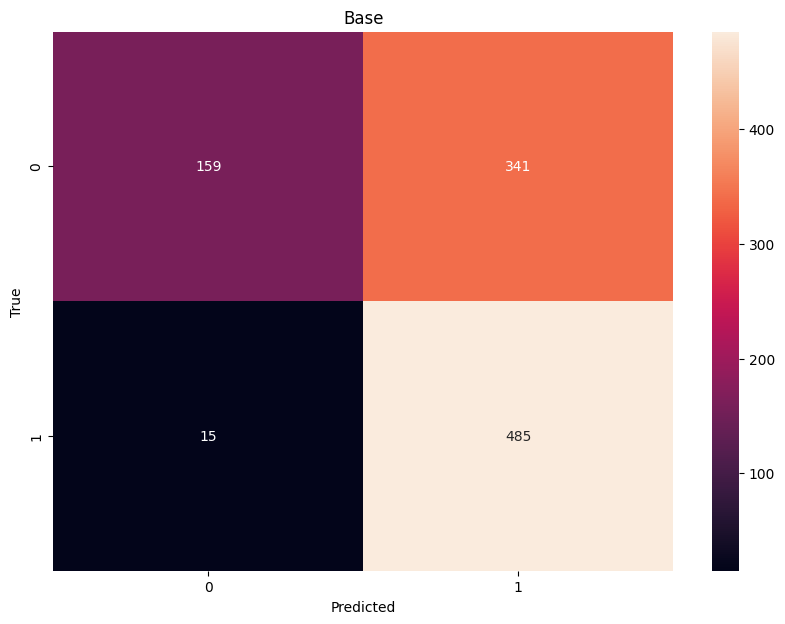

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 698ms/step


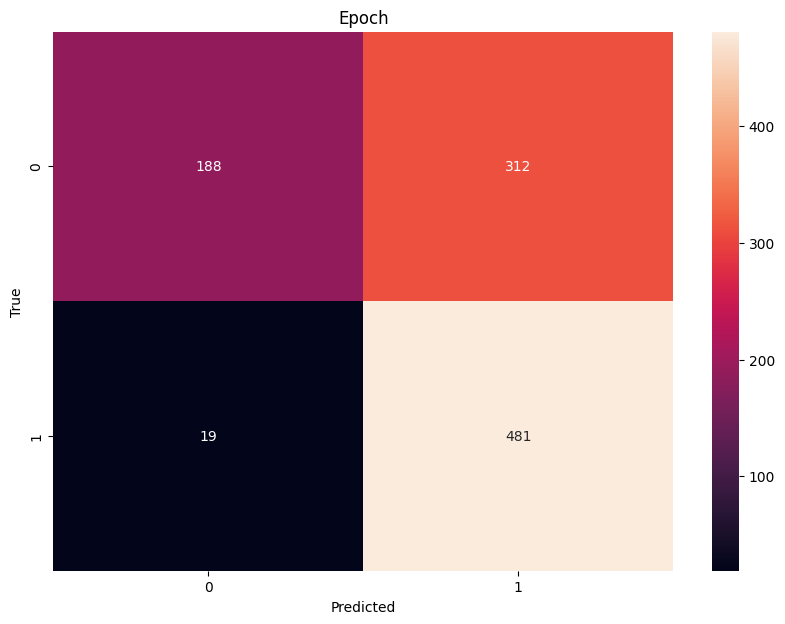

32/32 ━━━━━━━━━━━━━━━━━━━━ 23s 699ms/step


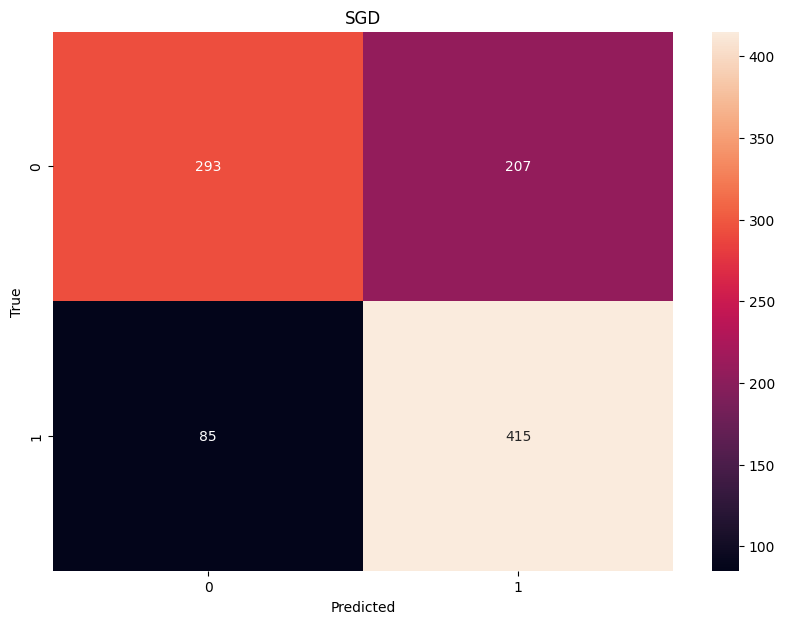

 9/32 ━━━━━━━━━━━━━━━━━━━━ 16s 731ms/step

In [ ]:
model_eval = Evaluate_model(test_generator)

#Test metrics
model_eval.calc_metrics(base, 'Base')
model_eval.calc_metrics(epoch, 'Epoch')
model_eval.calc_metrics(sgd, 'SGD')
model_eval.calc_metrics(sigmoid_model, 'Sigmoid')
model_eval.calc_metrics(valsteps, 'ValSteps')

model_eval.test_table.to_csv('/kaggle/working/model_eval_test_table.csv')

model_eval.add_history(base_history, 'Base')
model_eval.add_history(epoch_history, 'Epoch')
model_eval.add_history(sgd_history, 'SGD')
model_eval.add_history(sigmoid_history, 'Sigmoid')
model_eval.add_history(valsteps_history, 'ValSteps')

#Visualize training histories
model_eval.visualize_training(['accuracy', 'val_accuracy', 'loss', 'val_loss'])

#Plot confusion matrices
model_eval.plot_confusion_matrix(base, 'Base')
model_eval.plot_confusion_matrix(epoch, 'Epoch')
model_eval.plot_confusion_matrix(sgd, 'SGD')
model_eval.plot_confusion_matrix(sigmoid_model, 'Sigmoid')
model_eval.plot_confusion_matrix(valsteps, 'ValSteps')

#Plot roc curve
model_eval.plot_roc_curve(base, 'Base ROC')
model_eval.plot_roc_curve(epoch, 'Epoch ROC') 
model_eval.plot_roc_curve(sgd, 'SGD ROC')
model_eval.plot_roc_curve(sigmoid_model, 'Sigmoid ROC')
model_eval.plot_roc_curve(valsteps, 'ValSteps ROC')

# Archived code

In [ ]:
#     def define_architecture_old(self):
        
#         model = Sequential([
#             Conv2D(32, (3, 3), activation=self.activation, input_shape=(224, 224, 3)),
#             MaxPooling2D(2, 2),
#             Conv2D(64, (3, 3), activation=self.activation),
#             MaxPooling2D(2,2),
#             Conv2D(128, (3, 3), activation=self.activation),
#             MaxPooling2D(2,2),
#             Flatten(),
#             Dropout(0.5),
#             Dense(512, activation=self.activation),
#             Dense(2, activation='softmax')
#         ])
#         return model